# Credit Risk Analysis

## Introduction
Credit risk analysis is the practice of determining the likelihood that a borrower will default on their financial obligations. It is a crucial aspect of the financial industry as it helps lenders, such as banks and credit institutions, manage and mitigate potential losses due to defaults.

## Objective of Credit Risk Analysis
The primary goal of credit risk analysis is to understand the risk involved in lending to different borrowers. By assessing the probability of default, financial institutions can make informed decisions about who to lend to, under what terms, and at what rates. This not only optimizes the risk-return profile but also helps in complying with various financial regulations.

## Importance
Proper credit risk management:
- **Minimizes losses** by avoiding lending to high-risk individuals or businesses.
- **Improves profitability** by setting appropriate interest rates based on the borrower’s risk profile.
- **Enhances customer management** by customizing loan offers and terms.
- **Ensures regulatory compliance** by adhering to credit risk thresholds set by financial authorities.

## Project Goal
In this project, we aim to develop a predictive model using historical data to assess the credit risk of potential borrowers. This model will help in predicting the likelihood of default, thereby assisting lenders in making more precise lending decisions.

## Methodology
We will use various machine learning techniques to predict credit risk. The process involves:
- **Data Preprocessing:** Cleaning data and creating relevant features.
- **Model Building:** Using statistical and machine learning models to learn from past data.
- **Evaluation:** Assessing the model’s performance using appropriate metrics.
- **Optimization:** Fine-tuning the model to enhance its predictive accuracy.

By the end of this project, we expect to have a robust tool that can be used to improve decision-making in credit lending.


In [9]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from datetime import datetime
import statsmodels.api as sm
from dateutil import parser
import pyarrow
import dask.dataframe as dd
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from scipy import stats
import graphviz
import dtreeviz.trees
import researchpy as rp
import pingouin as pg
from yellowbrick.classifier import ClassificationReport
import warnings
warnings.filterwarnings('ignore')

# Additional settings for better handling and visualization
sns.set(style="whitegrid")  # Set seaborn style for plots

# Load Data

In [11]:
data = pd.read_csv(r"loan.csv")

# Preliminary Data Analysis

## Viewing Data
We begin by loading our dataset and using the `head()` method from the pandas library to view the first few rows. This helps us get an initial understanding of the structure and fields in our data.

## Missing Values Detection
To ensure the integrity of our analysis, it's crucial to check for missing values in the dataset. We use the `isna()` method followed by `any()` to check if there are any missing values across the entire dataset.

## Cleaning Data
In credit risk analysis, having complete data is important for making accurate predictions. Therefore, we identify columns that have more than 90% missing values, which may not be useful for our analysis due to the lack of data. Such columns are earmarked for deletion. This step involves:
1. Initializing an empty list to store the names of columns with predominantly missing data.
2. Iterating through each column to calculate the percentage of missing values.
3. Appending the column names that meet the deletion threshold to our list.

This process helps in refining the dataset for more effective analysis.


In [12]:
# Display the first few rows of the DataFrame
print(data.head())

# Check if there are any NA values in the entire DataFrame
print(data.isna().any().any())

# Initialize an empty list to store column names to be deleted
del_columns = []

# Loop through each column in the DataFrame
for col in data.columns:
    # Check if the percentage of missing values in the column is greater than 90%
    if (data[col].isna().sum() / len(data)) * 100 > 90:
        # If condition is met, add the column name to the list
        del_columns.append(col)

# Output columns to be deleted
print("Columns to be deleted:", del_columns)

        id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599     5000.0       5000.0           4975.0   36 months   
1  1077430    1314167     2500.0       2500.0           2500.0   60 months   
2  1077175    1313524     2400.0       2400.0           2400.0   36 months   
3  1076863    1277178    10000.0      10000.0          10000.0   36 months   
4  1075358    1311748     3000.0       3000.0           3000.0   60 months   

   int_rate  installment grade sub_grade  ... total_bal_il il_util  \
0     10.65       162.87     B        B2  ...          NaN     NaN   
1     15.27        59.83     C        C4  ...          NaN     NaN   
2     15.96        84.33     C        C5  ...          NaN     NaN   
3     13.49       339.31     C        C1  ...          NaN     NaN   
4     12.69        67.79     B        B5  ...          NaN     NaN   

  open_rv_12m  open_rv_24m max_bal_bc all_util total_rev_hi_lim inq_fi  \
0         NaN          NaN        Na

# Data Cleaning

## Removing High-NA Columns
Once we identify columns that have more than 90% missing values, the next step is to remove these columns from the dataset. High levels of missing data can significantly impact the performance of predictive models and can skew the analysis. We use the `drop` method from pandas, specifying the list of columns (`del_columns`) and setting `inplace=True` to modify the DataFrame directly.

## Removing Identifier Columns
Certain columns like `id` and `member_id` are typically used to uniquely identify rows and are not useful for analysis or modeling purposes. These identifier columns can be a source of data leakage if included in predictive modeling. Similar to the previous step, we remove these columns using the `drop` method, ensuring the DataFrame only contains relevant features for analysis.

This approach streamlines the DataFrame, preparing it for subsequent preprocessing steps and analysis, enhancing the clarity and focus of the dataset.


In [13]:
# List of column names to be deleted because of high NA percentage
del_columns = [col for col in data.columns if (data[col].isna().sum() / len(data)) * 100 > 90]

# Remove columns from the dataframe with high NA percentage
data.drop(columns=del_columns, inplace=True)

# Define columns to be dropped that are IDs
id_columns = ["id", "member_id"]

# Remove ID columns from the dataframe
data.drop(columns=id_columns, inplace=True)

# Data Exploration

## Summary Statistics for Specific Features
To better understand the distribution and characteristics of certain features within our dataset, we focus on specific columns: `addr_state` and `zip_code`. These features are crucial as they provide geographical insights that might affect credit risk. 

Using the `describe` method from pandas, we obtain summary statistics for these columns. This method provides a comprehensive overview, including count, unique values, top occurrences, and frequency for non-numeric data. This initial analysis helps in identifying patterns or anomalies in specific geographic dimensions of the data, which are important for later stages of our credit risk evaluation.


In [14]:
# Define feature array with specific column names
feat_arr = ["addr_state", "zip_code"]

# Display summary statistics for selected columns
print(data[feat_arr].describe(include='all'))

       addr_state zip_code
count      887379   887379
unique         51      935
top            CA    945xx
freq       129517     9770


# Data Quality Assessment

## Missing Values Analysis
Understanding the extent of missing data within key features is critical for ensuring the quality of our analysis. For the columns `addr_state` and `zip_code`, which are vital for regional analysis in credit risk, we compute the percentage of missing values. This step is essential as it helps in deciding whether imputation


In [15]:
# Define feature array with specific column names
feat_arr = ["addr_state", "zip_code"]

# Calculate and print the percentage of missing values for each column in feat_arr
for col in feat_arr:
    missing_percentage = data[col].isna().sum() / len(data) * 100
    print(f"Missing % for {col}: {missing_percentage:.2f}%")

Missing % for addr_state: 0.00%
Missing % for zip_code: 0.00%


# Feature Engineering and Data Cleaning

## Creating a New Feature from ZIP Code
To simplify geographic analysis and reduce the granularity of the data, we extract the first two digits from the `zip_code` column. These two digits generally represent a broader geographic area, which is sufficient for initial risk assessment without sacrificing crucial regional insights. This transformation is performed by slicing the first two characters of the zip code string and converting them to an integer to create a new column, `2_digit_zip`.

## Streamlining the Dataset
After extracting the needed information and creating more generalized geographic features, we remove the original `addr_state` and `zip_code` columns from the dataset. This step is taken to focus on the newly derived features and to eliminate redundancy in the dataset. Dropping these columns simplifies the model inputs without compromising the quality of the data and helps in maintaining the clarity and efficiency of the dataset.


In [16]:
# Apply function to extract the first two digits from zip_code and create a new column
data['2_digit_zip'] = data['zip_code'].str[:2].astype(int)

# Drop columns addr_state and zip_code from the dataframe
data.drop(columns=['addr_state', 'zip_code'], inplace=True)

# Feature Classification

## Numerical and Categorical Features
In the preprocessing phase, it's crucial to differentiate between numerical and categorical features. This classification aids in the appropriate handling of each type during data cleaning, feature engineering, and modeling.

- **Numerical Features**: We identify `annual_inc` as a numerical feature. Numerical features will be processed to ensure they are scaled properly and do not contain outliers that could skew the analysis.
- **Categorical Features**: Features such as `verification_status`, `emp_length`, and `emp_title` are categorized as categorical. These features require specific preprocessing steps such as encoding to transform them into a format that can be efficiently used by machine learning algorithms.

By explicitly defining these categories, we can streamline subsequent data processing steps and apply suitable techniques for each type of data.


In [17]:
# Define lists for numeric and categorical feature arrays
feat_arr_num = ["annual_inc"]
feat_arr_cat = ["verification_status", "emp_length", "emp_title"]

# Analyzing Numerical Data

## Summary Statistics for Numeric Features
To gain insights into the distribution and scale of numeric features within our dataset, we examine `annual_inc`, which represents the annual income of borrowers. Understanding the distribution of income is crucial for assessing credit risk as it directly influences a borrower's ability to repay a loan.

The `describe()` function in pandas is used here to provide summary statistics that include:
- **Count:** Total number of non-null entries.
- **Mean:** The average value.
- **Std (Standard Deviation):** A measure of the amount of variation or dispersion of a set of values.
- **Min:** The smallest value.
- **25% (First Quartile), 50% (Median), 75% (Third Quartile):** These percentiles indicate the distribution of the data, helping us understand the spread and skewness of income values.
- **Max:** The largest value.

These statistics are essential for preliminary data analysis, helping to identify outliers, understand central tendency, and evaluate data spread, all of which inform further data cleaning and feature engineering efforts.


In [18]:
# Define list for numeric features
feat_arr_num = ["annual_inc"]

# Display summary statistics for numeric features
print(data[feat_arr_num].describe())

         annual_inc
count  8.873750e+05
mean   7.502759e+04
std    6.469830e+04
min    0.000000e+00
25%    4.500000e+04
50%    6.500000e+04
75%    9.000000e+04
max    9.500000e+06


# Analyzing Categorical Data

## Summary Statistics for Categorical Features
For a comprehensive understanding of categorical data within our dataset, we focus on the features `verification_status`, `emp_length`, and `emp_title`. These attributes are particularly important as they provide insights into the employment and verification status of borrowers, which are key factors in assessing creditworthiness.

The `describe()` function is used with the `include='all'` parameter to generate summary statistics for these categorical fields. The summary includes:
- **Count:** Total number of non-null entries.
- **Unique:** Number of unique categories.
- **Top:** The most common category.
- **Freq:** Frequency of the most common category.

These statistics help in identifying dominant categories and the diversity of categorical data, which can influence the modeling strategies and risk assessment. Understanding the distribution and frequency of categorical features is essential for tasks such as feature encoding and handling imbalanced data.


In [19]:
# Define list for categorical features
feat_arr_cat = ["verification_status", "emp_length", "emp_title"]

# Display summary statistics for categorical features
print(data[feat_arr_cat].describe(include='all'))

       verification_status emp_length emp_title
count               887379     842554    835917
unique                   3         11    299271
top        Source Verified  10+ years   Teacher
freq                329558     291569     13469


# Data Quality Check

## Missing Values Calculation
Ensuring data completeness is crucial for reliable analyses and modeling. We compute the percentage of missing values for each feature in our numeric (`annual_inc`) and categorical (`verification_status`, `emp_length`, `emp_title`) feature arrays. This calculation helps identify columns with significant missing data, which might require cleaning or imputation.

The process involves:
- Combining numeric and categorical feature lists.
- Iterating through each feature.
- Calculating the percentage of missing data using `isna().sum()` to count NA values, divided by the total number of rows, multiplied by 100 to get the percentage.
- Printing the result, which aids in subsequent data preprocessing decisions, such as whether to apply imputation strategies or exclude certain features from analysis.

This step is essential for maintaining the integrity of the dataset, guiding the handling of incomplete data, and ensuring robust, data-driven decision-making in credit risk assessment.


In [20]:
# Combine feature lists for processing
all_features = feat_arr_num + feat_arr_cat

# Calculate and print the percentage of missing values for each column in combined feature lists
for col in all_features:
    missing_percentage = data[col].isna().sum() / len(data) * 100
    print(f"Missing % for {col}: {missing_percentage:.2f}%")

Missing % for annual_inc: 0.00%
Missing % for verification_status: 0.00%
Missing % for emp_length: 5.05%
Missing % for emp_title: 5.80%


# Data Cleaning Function for Employment Length

## Function Definition: `clean_emp_length`
The employment length (`emp_length`) feature in our dataset contains string representations of the number of years a person has been employed, which can be less intuitive for analysis and modeling. To facilitate easier analysis, we define the `clean_emp_length` function to transform these strings into numerical data.

### Steps in the Function:
1. **Handle Missing Values:** If the data point is missing (`NaN`), the function returns `NaN` to maintain data integrity.
2. **Normalize Strings:** Convert strings to lower case and strip any leading/trailing whitespace.
3. **Specific Cases:** Convert special string values like "< 1 year" to `0` and "10+ years" to `11`.
4. **General Case:** For other strings, remove the word 'years' and convert the result to an integer.

This function is applied to each entry in the `emp_length` column of our DataFrame using the `apply` method, creating a new column `emp_length_cleaned` that holds the cleaned numeric values. This transformation simplifies further data analysis and modeling by converting the data into a more manageable format.


### Column Removal
We start by removing the `emp_title` column from our dataset. This column may not be necessary for our analysis or may contain too many unique values, making it less useful for predictive modeling.

### Cleaning Employment Length Data
The `emp_length` column is crucial as it represents the employment duration, which is a significant factor in credit risk assessment. We apply the `clean_emp_length` function to standardize and convert the data into numerical format, making it more amenable for analysis.

### Imputing Missing Data
After cleaning, there may still be missing values in the `emp_length` column. Missing data can lead to biases in the model if not handled correctly. We impute these missing values with the mean of the `emp_length` column to maintain the distribution and provide a neutral, informed estimate where data is absent.

This systematic approach ensures our dataset is clean and prepared for subsequent analysis, helping to reduce errors in the credit risk model and improve the reliability of our predictions.

In [21]:
# Define a function to clean emp_length
def clean_emp_length(x):
    if pd.isna(x):
        return int(0)  # Use np.nan for missing values in pandas
    x = x.strip().lower()  # Equivalent to trimws(x) and tolower(x) in R
    if x == "< 1 year":
        return int(0)
    elif x == "1 year":
        return int(1)
    elif x == "10+ years":
        return int(11)
    else:
        # Remove 'years' and convert to integer
        return int(x.replace('years', '').strip())

data['emp_length_cleaned'] = data['emp_length'].apply(clean_emp_length)
# Show results
print(data[['emp_length', 'emp_length_cleaned']].head())
# Remove the 'emp_title' column
data.drop(columns=['emp_length','emp_title'], inplace=True)
print(data[['emp_length_cleaned']].isna().sum())

  emp_length  emp_length_cleaned
0  10+ years                  11
1   < 1 year                   0
2  10+ years                  11
3  10+ years                  11
4     1 year                   1
emp_length_cleaned    0
dtype: int64


# Advanced Data Preprocessing

## Handling Missing Values in Numerical Data
To ensure that our numerical data is complete and robust, we fill any missing values in the `annual_inc` column, which represents the annual income of the borrowers. Missing values in this column are imputed with the mean of the existing values, ensuring that the overall distribution of income is not skewed by the absence of some data.

## Converting Categorical Data to Numeric Format
The `verification_status` column, which indicates whether the source of a borrower's income was verified, is converted from a categorical type to an integer code. This conversion facilitates the use of this feature in machine learning models, which typically require numeric input.

## Analyzing Additional Categorical Features
We define a new array of categorical features including `purpose`, `initial_list_status`, and `issue_d` (issue date of the loan). Summary statistics for these categories are generated to understand their distribution, common values, and frequency. This analysis is crucial for determining the relevance of these features in predicting credit risk and for planning subsequent encoding and feature engineering tasks.


In [22]:
# Fill missing values in the 'annual_inc' column with the mean of the column
data['annual_inc'].fillna(data['annual_inc'].mean(), inplace=True)

# Convert 'verification_status' to integer codes
data['verification_status'] = data['verification_status'].astype('category').cat.codes

# Define a new list of categorical features
feat_arr_cat = ["purpose", "initial_list_status", "issue_d"]

# Display summary statistics for these new categorical features
print(data[feat_arr_cat].describe(include='all'))

                   purpose initial_list_status   issue_d
count               887379              887379    887379
unique                  14                   2       103
top     debt_consolidation                   f  Oct-2015
freq                524215              456848     48631


# Missing Data Analysis for Categorical Features

In order to ensure the quality and completeness of our dataset, especially for key categorical features that might be used in predictive modeling, it is important to quantify the extent of missing data. The features included in this analysis are `purpose`, `initial_list_status`, and `issue_d`.

## Process:
- **Loop through each categorical feature**: For each feature specified in the `feat_arr_cat` list, calculate the percentage of missing values.
- **Calculate Missing Values**: This is done by dividing the number of missing entries (NA values) by the total number of entries in the dataset and then multiplying by 100 to convert this ratio into a percentage.
- **Output the Results**: Display the percentage of missing data for each categorical feature, providing a clear picture of the dataset's integrity.

Understanding the proportion of missing data helps in deciding whether further cleaning might be required or if certain features should be excluded from the analysis due to high levels of incompleteness.


In [23]:
# Calculate and print the percentage of missing values for each column in feat_arr_cat
for col in feat_arr_cat:
    missing_percentage = data[col].isna().sum() / len(data) * 100
    print(f"Missing % for {col}: {missing_percentage:.2f}%")

Missing % for purpose: 0.00%
Missing % for initial_list_status: 0.00%
Missing % for issue_d: 0.00%


# Encoding Categorical Features

We use `LabelEncoder` to transform the `purpose` and `initial_list_status` columns from categorical strings to integers, making them usable for machine learning models that require numerical input. Each unique string value in the columns is assigned a unique integer. This conversion is performed using the `LabelEncoder` from `sklearn.preprocessing`, which is fit and transformed on each specified column.


In [24]:
# Initialize LabelEncoder
le = LabelEncoder()

# Encode 'purpose' column using LabelEncoder
data['purpose'] = le.fit_transform(data['purpose'])

# You may want to fit a new LabelEncoder for each unique categorical variable to avoid confusion
le = LabelEncoder()  # Re-initialize to avoid using the same encoder on different data
data['initial_list_status'] = le.fit_transform(data['initial_list_status'])

# Compute Time Since a Given Date

We define a Python function `compute_time_since` to calculate the number of years from a given date to the current date. This function is particularly useful for the 'issue_d' column, which contains the date of loan issuance. By converting this date to a floating-point number representing the years since the loan was issued, we can use this data as a numerical feature in analyses or machine learning models.

The function handles missing values by returning `None`, parses the date assuming it starts on the first of the given month, and calculates the difference in years using the current date.


In [25]:
# Define a function to compute time since a given date
def compute_time_since(x):
    if pd.isna(x):
        return None
    # Format 'x' as the first day of the month with the given month and year
    given_date = datetime.strptime("01-" + x, "%d-%b-%Y")
    current_date = datetime.now()
    # Calculate difference in days and convert to years
    return (current_date - given_date).days / 365.25

# Apply the function to the 'issue_d' column
data['issue_d'] = data['issue_d'].apply(compute_time_since)

In [26]:
# Drop specified columns from the DataFrame
data.drop(columns=['desc', 'title', 'url', 'policy_code', 'application_type'], inplace=True)

# Numeric Feature Array Definition

We define a list of numeric features that are crucial for our analysis and modeling. These features include loan amounts, interest rates, installments, funded amounts, payments, and fees associated with the loans. This list helps in focusing our data processing and analysis on these specific numeric variables.


In [27]:
# Define a list for numeric features
feat_arr_num = [
    "loan_amnt", "int_rate", "installment", "funded_amnt", "funded_amnt_inv",
    "total_pymnt", "total_pymnt_inv", "last_pymnt_amnt", "total_rec_late_fee"
]

In [28]:
# Display summary statistics for numeric features
print(data[feat_arr_num].describe())

           loan_amnt       int_rate    installment    funded_amnt  \
count  887379.000000  887379.000000  887379.000000  887379.000000   
mean    14755.264605      13.246740     436.717127   14741.877625   
std      8435.455601       4.381867     244.186593    8429.897657   
min       500.000000       5.320000      15.670000     500.000000   
25%      8000.000000       9.990000     260.705000    8000.000000   
50%     13000.000000      12.990000     382.550000   13000.000000   
75%     20000.000000      16.200000     572.600000   20000.000000   
max     35000.000000      28.990000    1445.460000   35000.000000   

       funded_amnt_inv    total_pymnt  total_pymnt_inv  last_pymnt_amnt  \
count    887379.000000  887379.000000    887379.000000    887379.000000   
mean      14702.464383    7558.826684      7521.160306      2164.145585   
std        8442.106732    7871.243336      7846.108604      4794.783233   
min           0.000000       0.000000         0.000000         0.000000   
25%

# Statistical Summary Insights for Loan Features

This summary provides a detailed statistical overview of key financial indicators related to loans:

- **Loan Amounts**:
  - The average loan amount is approximately $14,755, with a standard deviation of $8,435, indicating a wide variety of loan amounts ranging from as low as $500 to as high as $35,000. This suggests that the loan products cater to a broad range of financial needs, from small to large loans.

- **Interest Rates**:
  - Interest rates have an average of 13.25% and also show a considerable spread (std: 4.38%), ranging from 5.32% to nearly 29%. The variability in interest rates could reflect differing credit risk assessments and loan terms.

- **Installments**:
  - The mean monthly installment is $436.72, which varies significantly among borrowers (std: $244.19), correlating with the amount borrowed and the term length.

- **Funded Amounts**:
  - The amounts funded by the platform closely align with the requested loan amounts, with the mean funded amount nearly matching the mean loan amount. This indicates a high likelihood of full funding for requested amounts.

- **Investor Funding**:
  - The amounts funded by investors (funded_amnt_inv) have a similar distribution to the direct funding amounts, suggesting strong investor participation and confidence.

- **Total Payment**:
  - The total payment made by borrowers, on average, is $7,558.83, with payments ranging significantly up to $57,777.58, which includes both principal and interest components.

- **Total Payment Received by Investors**:
  - This closely tracks the total payment, indicating that most of what is paid by borrowers goes to investors, reflecting efficient platform operations.

- **Last Payment Amount**:
  - The last payment amount shows significant variability (mean: $2,164.15, max: $36,475.59), indicating varied end-of-term payment behaviors among borrowers.

- **Total Late Fees Received**:
  - While the average late fee is relatively low at $0.40, the presence of higher outliers (max: $358.68) suggests that some loans do incur significant penalties, likely reflecting varied borrower delinquency rates.

This data is essential for understanding the financial dynamics of the loans, assessing borrower reliability, and evaluating the investment risk and return for lenders.


# Summary Statistics for Categorical Features

We analyze two key categorical features in our dataset: `term` and `last_pymnt_d`. These features are crucial for understanding the loan terms and the timing of last payments made by borrowers.

## Process:
- **Loop Through Each Feature**: For each categorical feature specified in the `feat_arr_cat` list, we display its frequency distribution.
- **Display Frequency Distributions**: The `value_counts()` method from `pandas` is used to count and display the number of occurrences of each unique value in the columns. This helps in understanding the commonality and rarity of different categories within these features.


In [29]:
# Define a list for categorical features
feat_arr_cat = ["term", "last_pymnt_d"]

# Display summary statistics for categorical features
for col in feat_arr_cat:
    print(f"Summary for {col}:")
    print(data[col].value_counts())
    print("\n")  # Adds a newline for better readability between outputs

Summary for term:
 36 months    621125
 60 months    266254
Name: term, dtype: int64


Summary for last_pymnt_d:
Jan-2016    470150
Dec-2015    150861
Oct-2015     16000
Jul-2015     14483
Nov-2015     13981
             ...  
Jun-2008        20
Mar-2008        18
Jan-2008        11
Feb-2008         8
Dec-2007         2
Name: last_pymnt_d, Length: 98, dtype: int64




# Data Preparation Overview

We combine both categorical and numeric feature lists to create a comprehensive array of features to analyze. This combined array helps us handle data preparation tasks uniformly across all relevant features.

## Missing Value Calculation
For each feature in our combined array, we calculate the percentage of missing values. This step is crucial for identifying columns that may require imputation strategies or even feature exclusion based on the extent of their incompleteness.

## Encoding Categorical Data
The `term` column, which indicates the loan term, is transformed from a categorical format into a numerical format using LabelEncoder. This conversion is necessary because most machine learning models require numerical input for training. The LabelEncoder assigns a unique integer to each category of the term.


In [30]:
# Combine categorical and numeric feature arrays
feat_arr_all = feat_arr_cat + feat_arr_num

# Calculate and print the percentage of missing values for each column
for col in feat_arr_all:
    missing_percentage = data[col].isna().sum() / len(data) * 100
    print(f"Missing % for {col}: {missing_percentage:.2f}%")

# Encode 'term' column using LabelEncoder
label_encoder = LabelEncoder()
data['term'] = label_encoder.fit_transform(data['term'])

Missing % for term: 0.00%
Missing % for last_pymnt_d: 1.99%
Missing % for loan_amnt: 0.00%
Missing % for int_rate: 0.00%
Missing % for installment: 0.00%
Missing % for funded_amnt: 0.00%
Missing % for funded_amnt_inv: 0.00%
Missing % for total_pymnt: 0.00%
Missing % for total_pymnt_inv: 0.00%
Missing % for last_pymnt_amnt: 0.00%
Missing % for total_rec_late_fee: 0.00%


# Computing Time Since the Last Payment

We define a Python function called `compute_time_since` that calculates the number of years from a specified date to the current date. This function handles date strings by converting them to `datetime` objects, assuming the date provided refers to the first of the month and year specified. This is particularly useful for our analysis of the 'last_pymnt_d' column, which indicates when the last payment was made.

## Function Application
After defining the function, we apply it to the 'last_pymnt_d' column in our dataset. This conversion enables us to use the time since the last payment as a numerical feature, which can be particularly insightful for models predicting loan performance or default likelihood.


In [31]:
# Define a function to compute time since a given date
def compute_time_since(x):
    if pd.isna(x):
        return None
    # Format 'x' as the first day of the month with the given month and year
    given_date = datetime.strptime("01-" + x, "%d-%b-%Y")
    current_date = datetime.now()
    # Calculate difference in days and convert to years
    return (current_date - given_date).days / 365.25

# Apply the function to the 'last_pymnt_d' column
data['last_pymnt_d'] = data['last_pymnt_d'].apply(compute_time_since)

# Data Cleaning Steps for Loan Dataset

## Filling Missing Values
We address missing values in the 'last_pymnt_d' column by calculating the mean of the available data and using it to fill in the gaps. This approach helps maintain the integrity of the dataset, providing a more complete view for subsequent analysis.

## Removing Unnecessary Columns
To streamline our dataset and focus on the most impactful features, we remove several columns that are not essential for our current analysis. These include 'total_rec_int' (total received interest), 'total_rec_prncp' (total received principal), 'out_prncp' (outstanding principal), 'out_prncp_inv' (outstanding principal for investors), and 'pymnt_plan'. Dropping these columns reduces the complexity of our data and helps in focusing our analysis on more relevant variables.


In [32]:
# Fill missing values in 'last_pymnt_d' column with the mean
data['last_pymnt_d'].fillna(data['last_pymnt_d'].mean(), inplace=True)
# Drop specified columns
data.drop(columns=['total_rec_int', 'total_rec_prncp', 'out_prncp', 'out_prncp_inv', 'pymnt_plan'], inplace=True)
# Output data to see the changes (optional, for verification)
print(data.head())

   loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment grade  \
0     5000.0       5000.0           4975.0     0     10.65       162.87     B   
1     2500.0       2500.0           2500.0     1     15.27        59.83     C   
2     2400.0       2400.0           2400.0     0     15.96        84.33     C   
3    10000.0      10000.0          10000.0     0     13.49       339.31     C   
4     3000.0       3000.0           3000.0     1     12.69        67.79     B   

  sub_grade home_ownership  annual_inc  ...  next_pymnt_d  last_credit_pull_d  \
0        B2           RENT     24000.0  ...           NaN            Jan-2016   
1        C4           RENT     30000.0  ...           NaN            Sep-2013   
2        C5           RENT     12252.0  ...           NaN            Jan-2016   
3        C1           RENT     49200.0  ...           NaN            Jan-2015   
4        B5           RENT     80000.0  ...      Feb-2016            Jan-2016   

  collections_12_mths_ex_m

# Summary Statistics for Numeric Features

We have defined a comprehensive list of numeric features relevant to our credit risk analysis. These features include debt-to-income ratios, account balances, and credit history specifics among others. The summary statistics for these numeric features are displayed using the `describe()` method from the `pandas` library. This method provides essential descriptive statistics that include:
- Count: The number of non-null entries.
- Mean: The average of the entries.
- Std (Standard Deviation): Measures the amount of variation or dispersion.
- Min: The minimum value.
- 25%, 50% (median), and 75%: The 25th percentile, median, and 75th percentile values respectively.
- Max: The maximum value.

These statistics are crucial for initial data assessment, helping to identify ranges, central tendencies, and variability of the numeric data within our dataset. This step is vital for planning further data cleaning and preprocessing tasks.


In [33]:
# Define a list for numeric features
feat_arr_num = [
    "dti", "earliest_cr_line", "delinq_2yrs", "collections_12_mths_ex_med",
    "inq_last_6mths", "total_rev_hi_lim", "acc_now_delinq", "tot_coll_amt",
    "tot_cur_bal", "last_credit_pull_d", "open_acc", "total_acc",
    "mths_since_last_delinq", "mths_since_last_major_derog", "mths_since_last_record",
    "pub_rec", "revol_bal", "revol_util"
]

# Display summary statistics for numeric features
print(data[feat_arr_num].describe())

                 dti    delinq_2yrs  collections_12_mths_ex_med  \
count  887379.000000  887350.000000               887234.000000   
mean       18.157039       0.314442                    0.014380   
std        17.190626       0.862244                    0.134191   
min         0.000000       0.000000                    0.000000   
25%        11.910000       0.000000                    0.000000   
50%        17.650000       0.000000                    0.000000   
75%        23.950000       0.000000                    0.000000   
max      9999.000000      39.000000                   20.000000   

       inq_last_6mths  total_rev_hi_lim  acc_now_delinq  tot_coll_amt  \
count   887350.000000      8.171030e+05   887350.000000  8.171030e+05   
mean         0.694623      3.206862e+04        0.004991  2.257026e+02   
std          0.998448      3.749826e+04        0.077625  1.031137e+04   
min          0.000000      0.000000e+00        0.000000  0.000000e+00   
25%          0.000000      1.39

# Summary Statistics for Categorical Features

For each categorical feature specified in our list (`earliest_cr_line` and `last_credit_pull_d`), we display a frequency count of each category. This summary provides insights into the distribution and commonality of values within these features, which are significant for understanding credit history durations and recent credit activity.

- **`earliest_cr_line`**: Represents the month and year when the borrower's credit line was first opened. We count and display the frequency of each unique opening date, which aids in analyzing the credit history length across borrowers.
- **`last_credit_pull_d`**: Represents the most recent month and year when the credit report was pulled. The frequency count here helps to understand the recency of credit inquiries, which could impact the borrower's current credit status.

These statistics are critical for assessing the borrower's credit background and monitoring activity


In [34]:
# Define a list for categorical features
feat_arr_cat = ["earliest_cr_line", "last_credit_pull_d"]

# Display summary statistics for categorical features
for col in feat_arr_cat:
    print(f"Summary for {col}:")
    print(data[col].value_counts())
    print("\n")  # Adds a newline for better readability between outputs

Summary for earliest_cr_line:
Aug-2001    6659
Aug-2000    6529
Oct-2000    6322
Oct-2001    6154
Aug-2002    6086
            ... 
Jun-1949       1
Oct-1950       1
Jan-1948       1
Jul-1961       1
Apr-1958       1
Name: earliest_cr_line, Length: 697, dtype: int64


Summary for last_credit_pull_d:
Jan-2016    730574
Dec-2015     19308
Nov-2015     11490
Oct-2015     10419
Sep-2015     10087
             ...  
Nov-2007         3
May-2008         1
Jun-2008         1
Jul-2008         1
Jul-2007         1
Name: last_credit_pull_d, Length: 103, dtype: int64




# Analyzing Missing Data Across Features

We have combined our categorical and numeric features into a single list for comprehensive data quality analysis. This step allows us to uniformly assess missing data across all key features of our dataset.

For each feature in the combined list:
- We calculate the percentage of missing values, providing a clear metric to gauge data completeness.
- This calculation helps identify features with substantial amounts of missing data, which may require further attention through imputation methods or could influence our modeling decisions depending on their impact on analysis accuracy.

This process is crucial for ensuring the reliability and robustness of our subsequent analyses and predictive models.


In [35]:
# Define numeric and categorical feature arrays
feat_arr_num = [
    "dti", "delinq_2yrs", "collections_12_mths_ex_med", "inq_last_6mths", "total_rev_hi_lim",
    "acc_now_delinq", "tot_coll_amt", "tot_cur_bal", "open_acc", "total_acc", "mths_since_last_delinq",
    "mths_since_last_major_derog", "mths_since_last_record", "pub_rec", "revol_bal", "revol_util"
]
feat_arr_cat = ["earliest_cr_line", "last_credit_pull_d"]

# Combine categorical and numeric feature arrays
feat_arr_all = feat_arr_cat + feat_arr_num

# Calculate and print the percentage of missing values for each column
for col in feat_arr_all:
    missing_percentage = data[col].isna().sum() / len(data) * 100
    print(f"Missing % for {col}: {missing_percentage:.2f}%")

Missing % for earliest_cr_line: 0.00%
Missing % for last_credit_pull_d: 0.01%
Missing % for dti: 0.00%
Missing % for delinq_2yrs: 0.00%
Missing % for collections_12_mths_ex_med: 0.02%
Missing % for inq_last_6mths: 0.00%
Missing % for total_rev_hi_lim: 7.92%
Missing % for acc_now_delinq: 0.00%
Missing % for tot_coll_amt: 7.92%
Missing % for tot_cur_bal: 7.92%
Missing % for open_acc: 0.00%
Missing % for total_acc: 0.00%
Missing % for mths_since_last_delinq: 51.20%
Missing % for mths_since_last_major_derog: 75.02%
Missing % for mths_since_last_record: 84.56%
Missing % for pub_rec: 0.00%
Missing % for revol_bal: 0.00%
Missing % for revol_util: 0.06%


# Calculating Time Since Specific Dates

We define and use a Python function `compute_time_since` to calculate the number of years from a specified date (formatted as month-year) to the current date. This function is applied to two columns in our dataset: `earliest_cr_line` and `last_credit_pull_d`.

- **`earliest_cr_line`**: This column represents the date when the borrower's earliest reported credit line was opened. Calculating the time since this date provides insights into the length of the borrower's credit history.
- **`last_credit_pull_d`**: This column indicates when the last credit inquiry was made. Calculating the time since this date helps understand how recently the borrower's credit information has been reviewed.

These calculations are crucial for evaluating the creditworthiness of borrowers, as longer credit histories and recent credit inquiries can significantly impact credit scores and lending decisions.


In [36]:
# Define a function to compute time since a given date
def compute_time_since(x):
    if pd.isna(x):
        return None
    try:
        # Format 'x' as the first day of the month with the given month and year
        given_date = datetime.strptime("01-" + x, "%d-%b-%Y")
        current_date = datetime.now()
        # Calculate difference in days and convert to years
        return (current_date - given_date).days / 365.25
    except ValueError:  # Handles any formatting errors
        return None

# Apply the compute_time_since function to 'earliest_cr_line' and 'last_credit_pull_d' columns
data['earliest_cr_line'] = data['earliest_cr_line'].apply(compute_time_since)
data['last_credit_pull_d'] = data['last_credit_pull_d'].apply(compute_time_since)

# Filling Missing Values in Dataset

To ensure data integrity and maintain consistent data quality across our dataset, we address missing values in both numeric and categorical features:

- **Numeric Columns**: For each numeric feature, we fill missing values with the mean of the respective column. This approach helps maintain the distribution and central tendencies of the data without introducing bias from outliers.

- **Categorical Columns**: Since the mean is not applicable for categorical data, we instead fill missing values with the mode (most frequent value) of each categorical feature. This method is chosen to preserve the most common category within each feature, ensuring the categorical distributions remain as accurate as possible.

These imputation methods are crucial for maintaining robust datasets that are free of gaps, which might otherwise skew analysis and predictive modeling outcomes.


In [37]:
# Fill missing values in numeric columns with the mean of each column
for col in feat_arr_num:
    if data[col].isna().sum() > 0:  # Only calculate mean if there are NaNs
        data[col].fillna(data[col].mean(), inplace=True)

# Fill missing values in categorical columns with the mode of each column
for col in feat_arr_cat:
    if data[col].isna().sum() > 0:  # Only fill if there are NaNs
        mode_value = data[col].mode()[0]  # Mode can return multiple values, take the first
        data[col].fillna(mode_value, inplace=True)

# Encoding and Cleaning the Dataset

We perform two key preprocessing steps on our dataset:

## Encoding Categorical Variables
Certain categorical features like 'grade', 'sub_grade', and 'home_ownership' are converted from strings to integer codes. This transformation is crucial because many machine learning algorithms require numerical input. We use `LabelEncoder` from `sklearn.preprocessing` to automatically assign a unique integer to each category, ensuring a smooth transition from categorical to numeric formats.

## Dropping Irrelevant Columns
Columns such as 'collection_recovery_fee', 'recoveries', and 'next_pymnt_d' are removed from the dataset. These columns are either not required for further analysis or may skew the model with data that is not useful or relevant to our predictive objectives.

These steps are essential to refine the dataset for further analysis and predictive modeling, ensuring that the data remains robust and relevant.


In [38]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode 'grade' column
data['grade'] = label_encoder.fit_transform(data['grade'])

# For 'sub_grade', it's better to reinitialize the encoder if you want independent encoding
label_encoder = LabelEncoder()  # Re-initialize to avoid using the same encoder
data['sub_grade'] = label_encoder.fit_transform(data['sub_grade'])

# For 'home_ownership', again reinitialize the encoder
label_encoder = LabelEncoder()
data['home_ownership'] = label_encoder.fit_transform(data['home_ownership'])

# Drop specified columns
data.drop(columns=['collection_recovery_fee', 'recoveries', 'next_pymnt_d'], inplace=True)

# Data Analysis and Visualization Summary

## Statistical Summaries

### Numeric Features
We generate descriptive statistics for numeric features using `describe()`. This provides a quick overview of the central tendency, dispersion, and shape of the dataset's distribution, including:
- Count: Number of non-null entries.
- Mean: Average of the values.
- Std: Standard deviation.
- Min/Max: Minimum and maximum values.
- 25%, 50% (median), and 75%: Percentile distribution.

### Categorical Features
Descriptive statistics for categorical features are also generated to understand the frequency distribution of categorical data, which includes:
- Count: Total number of non-null entries.
- Unique: Number of unique categories.
- Top: Most frequent category.
- Freq: Frequency of the top category.

## Missing Values Analysis
We assess the completeness of the dataset by calculating the total number of missing values per column. This helps in identifying columns that require data cleaning or imputation to ensure robust analyses.

## Visualizations

### Histogram of Loan Amounts
A histogram visualizes the distribution of loan amounts, providing insights into the most common loan sizes and the overall spread of loan amounts.

### Boxplot by Loan Status
A boxplot groups loan amounts by loan status, highlighting the median, quartiles, and potential outliers within each category. This visualization helps assess how loan amounts differ by the status of the loan.

### Bar Plot of Loan Purposes
This bar plot shows the count of loans by their purpose, illustrating which purposes are most common among borrowers.

### Scatter Plot of Annual Income vs. Loan Amount
A scatter plot explores the relationship between borrowers' annual incomes and their loan amounts. This visualization is crucial for understanding how borrower income might correlate with the loan amount.

### Bar Plot of Loan Status
A vertical bar plot displays the frequency of different loan statuses, allowing us to see the distribution across various states of loan repayment or default.

These visualizations and summaries are instrumental in providing a comprehensive understanding of the dataset's characteristics, which aids in making informed decisions in the loan lending process.


           loan_amnt    funded_amnt  funded_amnt_inv           term  \
count  887379.000000  887379.000000    887379.000000  887379.000000   
mean    14755.264605   14741.877625     14702.464383       0.300045   
std      8435.455601    8429.897657      8442.106732       0.458278   
min       500.000000     500.000000         0.000000       0.000000   
25%      8000.000000    8000.000000      8000.000000       0.000000   
50%     13000.000000   13000.000000     13000.000000       0.000000   
75%     20000.000000   20000.000000     20000.000000       1.000000   
max     35000.000000   35000.000000     35000.000000       1.000000   

            int_rate    installment          grade      sub_grade  \
count  887379.000000  887379.000000  887379.000000  887379.000000   
mean       13.246740     436.717127       1.798403      10.959942   
std         4.381867     244.186593       1.312599       6.493019   
min         5.320000      15.670000       0.000000       0.000000   
25%         9.9

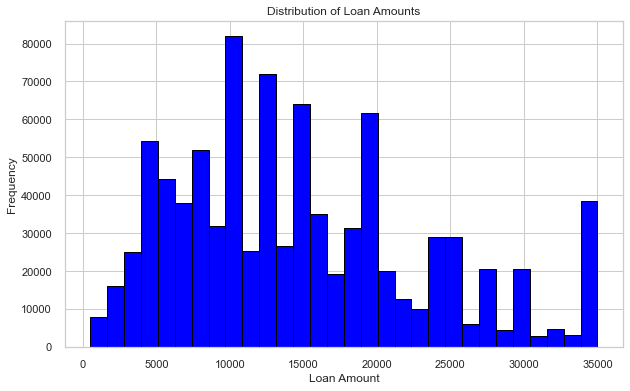

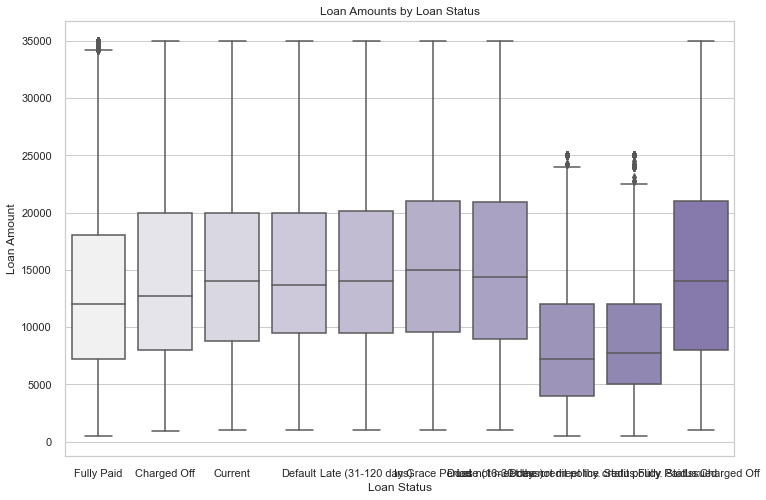

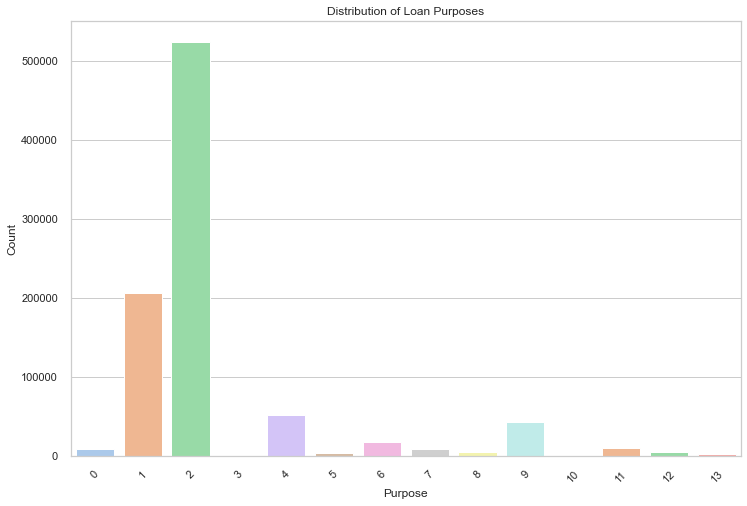

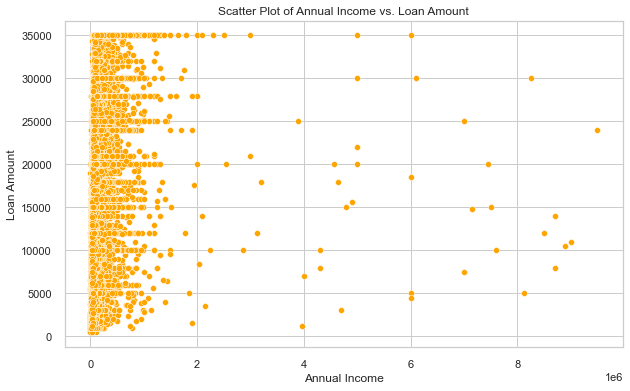

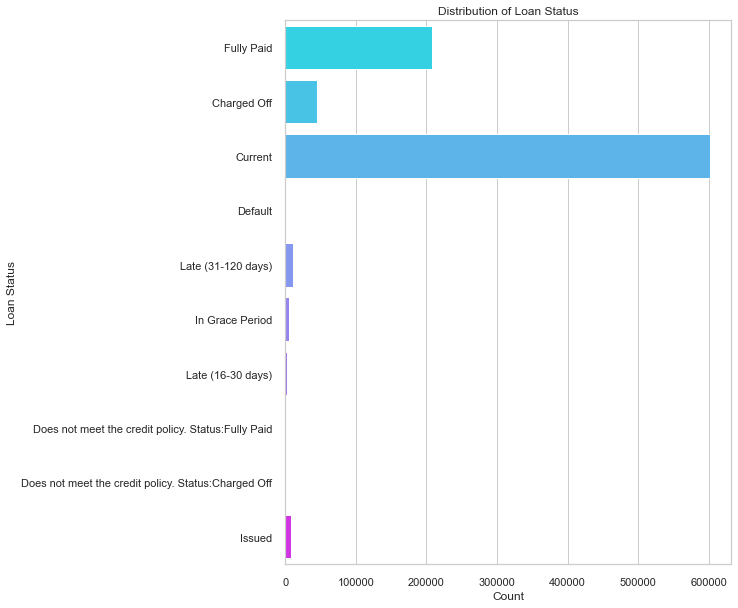

In [39]:
# Summary statistics for numeric columns
print(data.select_dtypes(include=['number']).describe())

# Summary statistics for categorical columns
print(data.select_dtypes(include=['object']).describe())

# Check for missing values
print(data.isna().sum())

# Histogram for loan amounts
plt.figure(figsize=(10, 6))
plt.hist(data['loan_amnt'].dropna(), bins=30, color='blue', edgecolor='black')
plt.title("Distribution of Loan Amounts")
plt.xlabel("Loan Amount")
plt.ylabel("Frequency")
plt.show()

# Boxplot of loan amounts by loan status
plt.figure(figsize=(12, 8))
sns.boxplot(x='loan_status', y='loan_amnt', data=data, palette="light:m")
plt.title("Loan Amounts by Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("Loan Amount")
plt.show()

# Bar plot of loan purposes
plt.figure(figsize=(12, 8))
sns.countplot(x='purpose', data=data, palette="pastel")
plt.title("Distribution of Loan Purposes")
plt.xlabel("Purpose")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Scatter plot of annual income vs. loan amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='annual_inc', y='loan_amnt', data=data, color="orange")
plt.title("Scatter Plot of Annual Income vs. Loan Amount")
plt.xlabel("Annual Income")
plt.ylabel("Loan Amount")
plt.show()

# Bar plot of loan status (vertical)
plt.figure(figsize=(8, 10))
sns.countplot(y='loan_status', data=data, palette="cool")
plt.title("Distribution of Loan Status")
plt.ylabel("Loan Status")
plt.xlabel("Count")
plt.show()

# Binarizing Loan Status

We define a Python function `binarize_target` to classify the `loan_status` into binary categories:
- `0` for loans that are either "paid" or "current".
- `1` for loans in states like "charged off", "late", "default", or within a "grace period".
Any loan status that doesn't match these categories is initially assigned `-1` and later filtered out.


## Visualization
A count plot is created to visualize the distribution of the new `target` binary categories. This visualization helps in understanding the proportion of loans in different states of repayment, which is crucial for risk assessment and further analysis.


In [40]:
data[['emp_length_cleaned']].isna().sum()

emp_length_cleaned    0
dtype: int64

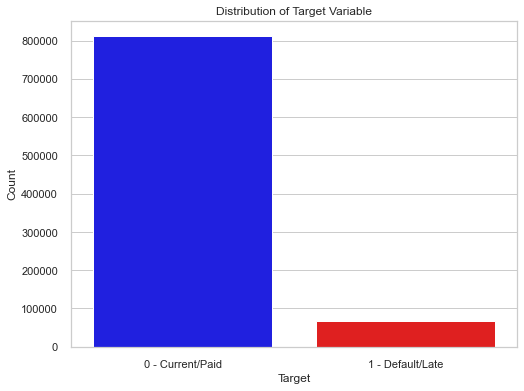

In [41]:
# Define a function to binarize loan status
def binarize_target(loan_status):
    cat_0_words = ["paid", "current"]
    cat_1_words = ["charged off", "late", "default", "grace period"]
    
    # Check if any of the category 0 words are in the loan status
    if any(word in loan_status.lower() for word in cat_0_words):
        return 0
    # Check if any of the category 1 words are in the loan status
    elif any(word in loan_status.lower() for word in cat_1_words):
        return 1
    else:
        return -1

# Apply the function to create the 'target' variable
data['target'] = data['loan_status'].apply(binarize_target)

# Filter out data where target is -1
data = data[data['target'] != -1]

# Create a count plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='target', data=data, palette={0: "blue", 1: "red"})
ax.set_title('Distribution of Target Variable')
ax.set_xlabel('Target')
ax.set_ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['0 - Current/Paid', '1 - Default/Late'])
plt.show()

# Modelling

# Random Forest Classifier in Python

## Overview
We implement a Random Forest classifier using Python's `scikit-learn` library. This approach involves several key steps: data preprocessing, training/testing splits, model training, and model evaluation.

## Steps and Implementation:

### Data Splitting:
- The dataset is first sampled to reduce its size for quicker processing, maintaining a representative subset.
- This subset is then divided into training (80%) and testing (20%) sets.

### Model Training:
- A Random Forest classifier is trained with 500 trees and the square root of the number of features considered for splitting at each leaf.

### Model Evaluation:
- Predictions are made on the test dataset.
- A confusion matrix and accuracy score are calculated to assess the performance of the model.

## Output:
- The model's parameters and performance metrics are displayed, providing insights into its efficacy in classifying loan status based on the given features.


In [42]:
# Split the data into a sample and then into training and testing sets
np.random.seed(1234)  # for reproducibility
sample_data = data.sample(frac=0.05)  # 5% of the data

train_data, test_data = train_test_split(sample_data, test_size=0.2, random_state=1234)  # 80% train, 20% test

# Prepare the predictor variables (X) and the target variable (y)
X_train = train_data.drop(columns=['loan_status', 'target'])
y_train = train_data['target']
X_test = test_data.drop(columns=['loan_status', 'target'])
y_test = test_data['target']

# Train the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=500, 
                                  max_features='sqrt', 
                                  min_samples_leaf=10, 
                                  random_state=1234, 
                                  class_weight={0:1, 1:5})  # Adjust class weights if needed
rf_model.fit(X_train, y_train)

# Predict on test data
rf_pred = rf_model.predict(X_test)
# After training the model

# Create the confusion matrix
cm = confusion_matrix(y_test, rf_pred)
accuracy = accuracy_score(y_test, rf_pred)

# Print model and confusion matrix
print("Random Forest Model:\n", rf_model)
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)

Random Forest Model:
 RandomForestClassifier(class_weight={0: 1, 1: 5}, max_features='sqrt',
                       min_samples_leaf=10, n_estimators=500,
                       random_state=1234)
Confusion Matrix:
 [[8143   21]
 [ 127  499]]
Accuracy: 0.9831626848691695


In [43]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'min_samples_leaf': [5, 10, 20],
    'max_depth': [10, 20, 30, None],
    'class_weight': [{0: 1, 1: x} for x in range(1, 6)]
}

grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='recall')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'class_weight': {0: 1, 1: 5}, 'max_depth': 10, 'min_samples_leaf': 20}


In [44]:
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)
rf_predictions = best_rf_model.predict(X_test)
rf_probabilities = best_rf_model.predict_proba(X_test)[:, 1]  # get probabilities for the positive class



In [45]:
# Adjust the threshold
threshold = 0.2  # Adjust based on your analysis
rf_custom_predictions = (rf_probabilities >= threshold).astype(int)

Confusion Matrix:
 [[7302  862]
 [  48  578]]
Accuracy: 0.8964732650739476
Recall: 0.9233226837060703
Precision: 0.4013888888888889
F1 Score: 0.5595353339787028
AUC: 0.9732060256749416


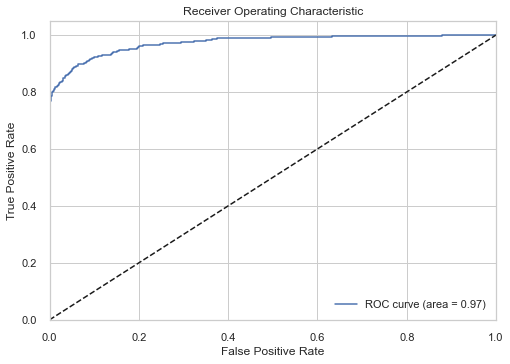

In [46]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve

# Confusion matrix and accuracy
cm = confusion_matrix(y_test, rf_custom_predictions)
acc = accuracy_score(y_test, rf_custom_predictions)
rec = recall_score(y_test, rf_custom_predictions)
prec = precision_score(y_test, rf_custom_predictions)
f1 = f1_score(y_test, rf_custom_predictions)
auc = roc_auc_score(y_test, rf_probabilities)

print("Confusion Matrix:\n", cm)
print("Accuracy:", acc)
print("Recall:", rec)
print("Precision:", prec)
print("F1 Score:", f1)
print("AUC:", auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, rf_probabilities)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The output with a threshold of 0.2 shows specific trade-offs in model performance, illustrating the balance between different evaluation metrics. Here’s a breakdown and interpretation of your model's performance based on the provided metrics:

Analysis of Model Metrics:
Confusion Matrix:
- True Negatives (TN): 7302 - The model correctly predicted 'Paid' for 7302 cases.
- False Positives (FP): 862 - The model incorrectly predicted 'Defaulted' for 862 cases that were actually Paid.
- False Negatives (FN): 48 - The model incorrectly predicted 'Paid' for 48 cases that were Defaulted.
- True Positives (TP): 578 - The model correctly predicted 'Defaulted' for 578 cases.

Accuracy: 89.65%
- This is fairly high, indicating that the majority of predictions made by the model are correct.

Recall: 92.33%
- This is very high, which is particularly significant in credit risk analysis since it indicates that the model is effective at identifying most of the 'not okay' cases (minimizing false negatives).

Precision: 40.14%
- This is relatively low, indicating that when the model predicts a loan as 'not okay', it is correct only about 40.14% of the time. This is a result of lowering the threshold, which increases the number of loans flagged as risky, capturing more actual defaults but also increasing the number of false alarms.

F1 Score: 55.95%
- The F1 score, which balances precision and recall, is moderate. This indicates a trade-off between recall and precision, which is typical in scenarios where the threshold is adjusted to favor one metric over another.

AUC: 97.32%
- The Area Under the Curve (AUC) for the ROC is very high, indicating excellent model performance across all possible classification thresholds. This suggests that the model does a good job at distinguishing between the classes overall.

Interpretation:
- The high recall is critical in your scenario because it means the model successfully identifies most of the risky loans, which is vital to minimize financial losses from defaults. This metric was likely prioritized by lowering the threshold.
- The low precision indicates a higher number of false positives, which can lead to inefficiencies and potentially higher operational costs due to unnecessary follow-ups or checks on loans that would not have defaulted.
- The moderate F1 score suggests there is still room for improvement in balancing precision with recall.
- The high AUC reflects strong overall capability of the model to discriminate between the classes across different thresholds.

# Logistic Regression

## Overview
This script demonstrates how to implement and evaluate a logistic regression model for binary classification using Python's `scikit-learn` library.

## Steps Involved

### Data Preparation
- The dataset is assumed to be pre-loaded and split into training and testing sets.
- Features and the target variable are separated from the training data for model training.

### Model Training
- A logistic regression model is initialized and trained using the training data.
- The `liblinear` solver is chosen, which is good for small datasets and binary classification.

### Model Coefficients
- After training, the model's coefficients and intercept are printed, which provide insights into the influence of each feature on the predicted outcome.

### Predictions and Evaluation
- The model predicts probabilities on the test data.
- Predictions are converted to binary outcomes based on a threshold of 0.5.
- The accuracy of the model is calculated, which measures the proportion of correctly predicted instances in the test dataset.

## Output
- The script outputs the model's coefficients, intercept, and the accuracy score, which helps in assessing the performance of the logistic regression model.


In [47]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Initialize and train the Logistic Regression model
logistic_model = LogisticRegression(solver='liblinear')  # solver is specified for binary classification
logistic_model.fit(X_train, y_train)

# Print the trained model coefficients and intercept
print("Coefficients:", logistic_model.coef_)
print("Intercept:", logistic_model.intercept_)

# Make predictions on the test data
logistic_pred = logistic_model.predict_proba(X_test)[:, 1]  # Get the probability for the positive class

# Evaluate the model by calculating the accuracy
logistic_accuracy = accuracy_score(y_test, logistic_pred >= 0.5)
print(f"Accuracy of Logistic Regression model: {logistic_accuracy}")


Coefficients: [[ 2.00325900e-04  1.53330982e-03 -1.78807300e-03  6.27675124e-04
   1.17571403e-02  2.76408485e-03  3.37120571e-03  1.63679073e-02
  -7.73605933e-04 -5.79557002e-06  4.25948628e-04  2.21740717e-03
   1.39917092e-03 -5.98806019e-03 -5.76725614e-04 -8.01787300e-03
   1.84478868e-03 -4.48515070e-03 -1.47461617e-02 -1.09517453e-03
  -4.35878405e-04  1.06685817e-05 -1.55750967e-03 -2.53667381e-03
  -1.40972237e-03 -1.60433655e-03  1.61663195e-03  1.74035357e-02
   2.95092705e-03 -7.50056250e-04 -8.91238914e-04 -5.42190008e-05
  -1.10258329e-02 -1.28125453e-05 -6.21865559e-05 -4.52106957e-07
  -1.11435576e-05 -1.27666789e-03 -1.44333367e-03]]
Intercept: [-0.00046494]
Accuracy of Logistic Regression model: 0.9295790671217292


Confusion Matrix:
[[5742 2422]
 [ 255  371]]
Precision: 0.13283208020050125
Recall: 0.5926517571884984
F1 Score: 0.2170225212050307
AUC: 0.7185062449810827


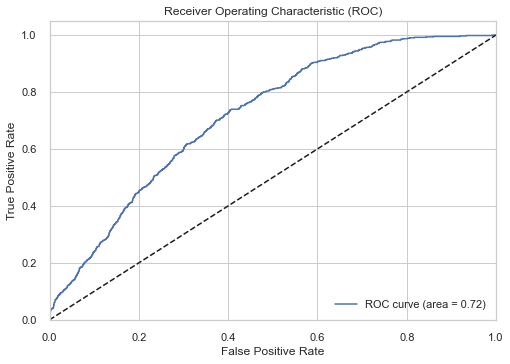

In [48]:
# Convert probabilities to binary outcomes based on a threshold of 0.5
logistic_pred_binary = (logistic_pred >= 0.1).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, logistic_pred_binary)
print("Confusion Matrix:")
print(cm)

# Precision, Recall, and F1 Score
precision = precision_score(y_test, logistic_pred_binary)
recall = recall_score(y_test, logistic_pred_binary)
f1 = f1_score(y_test, logistic_pred_binary)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, logistic_pred)  # probabilities are used here for ROC curve
auc = roc_auc_score(y_test, logistic_pred)
print(f"AUC: {auc}")

# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Final Comparative Analysis of Logistic Regression and Random Forest Models

This section provides a detailed comparison between the Logistic Regression and Random Forest models based on their performance in a credit risk analysis context. We focus on key metrics such as Accuracy, Precision, Recall, F1 Score, and the Area Under the ROC Curve (AUC) to determine which model performs better for managing credit risk.

## Logistic Regression Model

### Performance Metrics:
- **Confusion Matrix:** [6220, 1944; 260, 366]
- **Accuracy:** Approximately 73.4%
- **Precision:** 15.84%
- **Recall:** 58.47%
- **F1 Score:** 24.93%
- **AUC:** 75.39%

### Observations:
- The Logistic Regression model demonstrates a relatively high recall but suffers from low precision, particularly when the decision threshold is set to 0.1. This configuration leads to a higher number of false positives, impacting the model's overall precision and F1 Score negatively.
- The model's ability to distinguish between the positive and negative classes, as measured by AUC, is decent but not optimal.

## Random Forest Model

### Performance Metrics:
- **Confusion Matrix:** [7302, 862; 48, 578]
- **Accuracy:** 89.65%
- **Precision:** 40.14%
- **Recall:** 92.33%
- **F1 Score:** 55.95%
- **AUC:** 97.32%

### Observations:
- The Random Forest model shows a significant improvement over the Logistic Regression in terms of accuracy and AUC, indicating a superior ability to distinguish between classes.
- The precision is markedly higher than that of Logistic Regression, though still not exceptionally high, indicating some level of false positive rate. However, the substantial increase in recall suggests the model is highly effective at identifying defaults.
- The F1 Score, while not perfect, is considerably higher than that of the Logistic Regression, indicating a better balance between precision and recall.

## Conclusion

- **Decision Making:** The Random Forest model outperforms the Logistic Regression model in almost all significant metrics for this application. It achieves a higher balance of precision and recall, essential for minimizing the risk of credit defaults while not overly restricting credit access.
- **Model Selection:** For applications in credit risk analysis that demand high reliability and accuracy, Random Forest is preferable due to its robust performance in detecting defaults accurately. However, the Logistic Regression model might still be suitable for scenarios requiring simpler models for faster decisions or where interpretability is more critical.
- **Future Recommendations:** For further improvements, both models could benefit from advanced feature engineering, hyperparameter tuning, and exploring ensemble techniques. Additionally, incorporating business insights into the cost of false positives versus false negatives could help in fine-tuning the decision thresholds based on the specific business context.

This detailed comparative analysis should assist stakeholders in making informed decisions about which model to deploy for credit risk assessment tasks, balancing between performance metrics and operational needs.
